# **Finding Lane Lines on the Road** 
***
In this project:
- identify lane lines on the road.  
- develop  pipeline on a series of individual images, and to a video stream. 
- extrapolate the line segments you've detected to map out the full extent of the lane lines. 
- draw just one line for the left side of the lane, and one for the right.

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

('This image is:', <type 'numpy.ndarray'>, 'with dimesions:', (540, 960, 3))


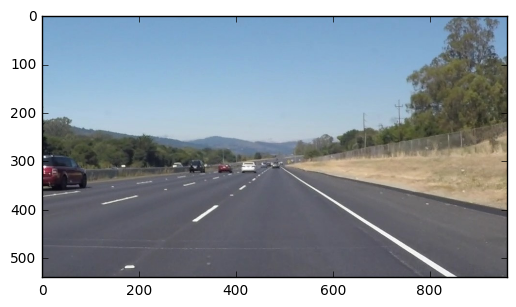

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

In [34]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    Gerti - Note: Vertices are ordered as <x, y>
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in np.array(line).reshape(1, 4):
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness = thickness)
    return line_img, lines



def weighted_img(img, initial_img, a=0.8, b=1., l=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * a + img * b + l
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, l)




def extract_edges(image, roi_verteces):
    '''
        Given a ROI, return edges on image with same size as original
        Function filters image first (low pass) to avoid high frequency
        spurious line detection. Then edges are detected on the whole
        image. ROI is implemented AFTER - to avoid introducing artificially, high
        frequencies into the edge detection process.
    :param image: Raw Image
    :param roi_verteces: Eges image <x, y> ordered
    :return:
    '''

    min_x = 0
    min_y = 0
    ctr_x = int(math.floor(image.shape[1] / 2.))
    ctr_y = int(math.floor(image.shape[0] / 2.))
    max_x = int(image.shape[1])
    max_y = image.shape[0]

    # Convert to gray scale image
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Edge detect (returns image with high pixels indicating edges)
    low_threshold = 150
    high_threshold = 220
    edges = canny(blur_gray, low_threshold, high_threshold)

    # ****** Extract ROI
    # Important: extract ROI only AFTER the edges have been extracted.
    #            ROI extraction introduces high frequency components to the
    #            image. This ends up causing artificual edges at the ROI eges
    try:
        roi_edges = region_of_interest(edges, roi_verteces)
    except Exception as ex:
        raise Exception(ex)

    return roi_edges


def hough_lines_from_edges(roi_edges):
    '''
        Generate lines using Hough transforms on edge image
    :param roi_edges:
    :return:
    '''
    # **************** Raw Line Extraction
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectable line segments
    try:
        # Draw lines on the edge image. Obtain the segment line objects
        edge_line_image, lines = hough_lines(roi_edges, rho, theta, threshold,
                                             min_line_length, max_line_gap, thickness=4)
    except Exception as ex:
        raise Exception(ex)

    return edge_line_image, lines



def extract_lines_naiive_hough(image, roi_verteces):
    '''
        Extract lines from ROI in image. Function extracts
        edges in ROI using canny edge detection. Then using
        OpenCV's Hough transform, extract the lines
    :param image: Raw image to process
    :param roi_verteces: ROI definition
    :return: Image with lines drawn, line objects (line segment endpoints), edge pixels used for line extraction
    '''

    # 1 - Extract edges in roi
    roi_edges = extract_edges(image=image, roi_verteces=roi_verteces)

    edge_line_image, lines = hough_lines_from_edges(roi_edges)

    # Draw the lines on the raw image
    raw_image_with_edges = weighted_img(img = edge_line_image,
                                        initial_img= np.copy(image),
                                        a=0.8, b=1., l=0.)

    return raw_image_with_edges, edge_line_image, lines, roi_edges


## Test on Images

Now build pipeline to work on the images in the directory "test_images"  

In [41]:
import os

run your solution on all test_images and make copies into the test_images directory).

# Encapsulate raw line generation: Naiive Hough Lines
## Capture the pipeline into one function

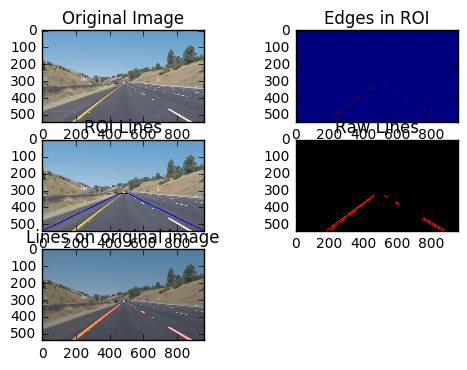

In [42]:
imgfolder = "test_images/"
image = mpimg.imread( imgfolder + 'whiteCarLaneSwitch.jpg')


x_idc = 0
y_idc = 1

min_x = 0
min_y = 0
ctr_x = int(math.floor(image.shape[1] / 2.))
ctr_y = int(math.floor(image.shape[0] / 2.))
max_x = int(image.shape[1])
max_y = image.shape[0]

# ROI Definition
left_bottom = (0, max_y)
right_bottom = (max_x, max_y)
center_bottom = (ctr_x, max_y)
apex = (ctr_x, ctr_y + 50)
apex_x_offset = int(math.floor(50/2.))


# Create a trapezius for ROI
verts = np.array([[(left_bottom[x_idc], left_bottom[y_idc]),
                   (apex[x_idc] - apex_x_offset, apex[y_idc]),
                   (apex[x_idc] + apex_x_offset, apex[y_idc]),
                   (right_bottom[x_idc], right_bottom[y_idc])]])



# ************ Debugging: Draw ROI bounding lines on the raw image *********
l1 = [left_bottom[x_idc], left_bottom[y_idc], apex[x_idc] - apex_x_offset, apex[y_idc]]
l2 = [apex[x_idc] - apex_x_offset, apex[y_idc], apex[x_idc] + apex_x_offset, apex[y_idc]]
l3 = [apex[x_idc] + apex_x_offset, apex[y_idc], right_bottom[x_idc], right_bottom[y_idc]]
l4 = [right_bottom[x_idc], right_bottom[y_idc], left_bottom[x_idc], left_bottom[y_idc]]
L = [l1, l2, l3, l4]
roi_lines_image = np.copy(image)
draw_lines(img=roi_lines_image, lines=L, color=[0, 0, 255], thickness=4)
# *************************************************************


# ************** Pipeline: Naiive Hough  ****************
# Extract lane lines using Canny edges and Hough Transforms - in ROI defined above
raw_image_with_edges, edge_line_image, lines, roi_edges = extract_lines_naiive_hough(image, roi_verteces = verts)


# Plot: just a sample to show how the lecture methods work. This is not final work.
plt.subplot(321)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(322)
plt.imshow(roi_edges)
plt.title('Edges in ROI')
plt.subplot(323)
plt.imshow(roi_lines_image)
plt.title('ROI Lines')
plt.subplot(324)
plt.imshow(edge_line_image)
plt.title('Raw Lines')
plt.subplot(325)
plt.imshow(raw_image_with_edges)
plt.title('Lines on original image')


# Extrapolating detected lane lines
### Issue: Edge detection generates spurious edges 

`NOTE: Please read conclusion comments section for a better explanation`

`Road craks, reflectors, vehicle ahead, etc genrate, pixelwise, valid lines. Such artifacts are sources of noise, w.r.t line detection.`

### Dealing with 2D sources of error
`Simple fitting (LS) assumes noise only on the dependent variable (Y). In reality, noise sources from both dimensions (X, Y) - spatial perception. 

1 - Total Least Squares (TLS) fit

2 - RANSAC: fit lines using probabilistic sampling
`

### How to deal with individual lane lines: Split ROI into left and right ROI
`Since the left and right lanes will be to the left and to the right, split the ROI into left and right`


### High frquency spatio-temporal noise
`
1 - Increase the thresholds of the edge generation to ignore faint line patterns from asphalt 
2 - Temporal rolling average filter to smoothen these fluctuations in time`


## Pipeline with TLS & RANSAC fitting

In [38]:
from scipy.odr import Model, ODR, Data
from scipy.stats import linregress
from sklearn import linear_model


def orthoregress(x, y):
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.
    Arguments:
    x: x data
    y: y data
    Returns:
    [m, c]
    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.

    Source: http://blog.rtwilson.com/orthogonal-distance-regression-in-python/
    """
    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(data = dat, model = mod, beta0=linreg[0:2], maxit=10)
    out = od.run()
    return list(out.beta)

def f(p, x):
    """
    Basic linear regression 'model' for use with ODR
    Source: http://blog.rtwilson.com/orthogonal-distance-regression-in-python/
    """
    return (p[0] * x) + p[1]


def lines_from_edge_points_RANSAC(edges, roi):

    roi = np.array(roi).reshape(-1,2)
    min_x= min(roi[:,0]); max_x = max(roi[:,0])
    min_y = min(roi[:,1]); max_y = max(roi[:,1])

    # Generate X,Y coordinates of the locations of non-zero values of edges
    res = np.nonzero(edges)
    x = np.array(res[1]).reshape(len(res[1]), -1)
    y = np.array(res[0]).reshape(len(res[0]), -1)

    # Fit line using all data
    model = linear_model.LinearRegression()
    # model = make_pipeline(PolynomialFeatures(2), Ridge())
    # model.fit(x, y)

    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(base_estimator=model)
    model_ransac.fit(x, y)

    inlier_mask = model_ransac.inlier_mask_
    # outlier_mask = np.logical_not(inlier_mask)

    # Compute the points generated within the x-range (min/max)
    x_range = np.array(range(min_x, max_x + 1))
    x_range = x_range.reshape(len(x_range), -1)

    # Predict data of estimated models
    y_range = np.array(np.around(model_ransac.predict(x_range), decimals=0), dtype=np.int64)


    # Y points in the x-ROI
    idc = (y_range >= min_y) & (y_range <= max_y)
    x_range = x_range[idc]
    y_range = y_range[idc]

    # min point / max point of line
    pt1 = (int(min(x_range)), int(y_range[x_range == min(x_range)][0]))
    pt2 = (int(max(x_range)), int(y_range[x_range == max(x_range)][0]))

    return pt1, pt2


def line_from_edge_points_TLS(edges, roi):
    '''
    Using the bounds of ROI and edge (pixels), fit TLS line model to edges.
    Then, generate the enpoints which are boun by the ROI
    :param edges: Edge image
    :return: fitted line endpoint segments as determined by ROI

    Author: Gerti Tuzi
            01/23/2017
    '''
    roi = np.array(roi).reshape(-1,2)
    min_x= min(roi[:,0]); max_x = max(roi[:,0])
    min_y = min(roi[:,1]); max_y = max(roi[:,1])
    # Generate X,Y coordinates of the locations of non-zero values of edges
    res = np.nonzero(edges)
    [m, c] = orthoregress(res[1], res[0])

    # Compute the points generated within the x-range (min/max)
    (x_range, y_range) = (np.array(range(min_x, max_x+1)), np.array(range(min_x, max_x+1))*m + c)

    # Y points in the x-ROI
    idc = (y_range >= min_y) & (y_range <= max_y)
    x_range = x_range[idc]
    y_range = y_range[idc]

    # min point / max point of line
    pt1 = (int(min(x_range)), int(y_range[x_range == min(x_range)][0]))
    pt2 = (int(max(x_range)), int(y_range[x_range == max(x_range)][0]))

    return pt1,pt2


def extract_lines_RANSAC_fitting(image, filtarr = None):
    '''
            Generate lane lines and draw on input image (returned copy)
            Split roi into L|R
            Use RANSAC fitting on edge pixels
            Draw fitted line on ime

        :param image: Source raw image
        :return: Raw image with lines drawn, raw line image
        '''

    x_idc = 0
    y_idc = 1

    min_x = 0
    min_y = 0
    ctr_x = int(math.floor(image.shape[1] / 2.))
    ctr_y = int(math.floor(image.shape[0] / 2.))
    max_x = int(image.shape[1])
    max_y = image.shape[0]

    # ROI Definition

    left_bottom = (0, max_y)
    right_bottom = (max_x, max_y)
    center_bottom = (ctr_x, max_y)
    apex = (ctr_x, ctr_y + 50)  # Push it down a bit to vanishing point
    apex_x_offset = int(math.floor(50 / 2.))

    # **************** Split the ROI into Left and Right
    L_verts = np.array([[(left_bottom[x_idc], left_bottom[y_idc]),
                         (apex[x_idc] - apex_x_offset, apex[y_idc]),
                         (apex[x_idc], apex[y_idc]),
                         (center_bottom[x_idc], center_bottom[y_idc])]])

    R_verts = np.array([[(center_bottom[x_idc], center_bottom[y_idc]),
                         (apex[x_idc], apex[y_idc]),
                         (apex[x_idc] + apex_x_offset, apex[y_idc]),
                         (right_bottom[x_idc], right_bottom[y_idc])]])

    # Obtain the edges for L|R ROI
    roi_edges_L = extract_edges(image=image, roi_verteces=L_verts)
    roi_edges_R = extract_edges(image=image, roi_verteces=R_verts)

    # Get the line endpoints from edges for each L|R side - using RANSAC fitting
    pt1L, pt2L = lines_from_edge_points_RANSAC(roi=L_verts, edges=roi_edges_L)
    pt1R, pt2R = lines_from_edge_points_RANSAC(roi=R_verts, edges=roi_edges_R)

    L = []
    if filtarr is not None:
        # Shift the filter
        for i in range(0, len(filtarr) - 1):
            filtarr[i, :] = filtarr[i + 1, :]
        filtarr[len(filtarr) - 1, :] = [pt1L[0], pt1L[1], pt2L[0], pt2L[1],
                                        pt1R[0], pt1R[1], pt2R[0], pt2R[1]]
        LL = np.around(filtarr.mean(axis=0), decimals=0).astype(int)
        L = [LL[0:4].tolist(), LL[4:8].tolist()]
    else:
        # Collect line endpoints
        L = [[pt1L, pt2L], [pt1R, pt2R]]

    # Combine both edges to plot for debugging
    roi_edges = roi_edges_L + roi_edges_R

    # Empty image to draw only the detected lines
    fitted_line_image = np.zeros_like(image)
    draw_lines(img=fitted_line_image, lines=L, color=[0, 0, 255], thickness=4)

    # Draw lines on the original image
    raw_image_with_lines = np.copy(image)
    draw_lines(img=raw_image_with_lines, lines=L, color=[255, 0, 0], thickness=4)

    return raw_image_with_lines, fitted_line_image, roi_edges


def extract_lines_TLS_fitting(image, filtarr = None):
    '''
        Generate lane lines and draw on input image (returned copy)
        Split roi into L|R
        Use TLS fitting to edge pixels
        Draw fitted line on ime

    :param image: Source raw image
    :return: Raw image with lines drawn, raw line image
    '''

    x_idc = 0
    y_idc = 1

    min_x = 0
    min_y = 0
    ctr_x = int(math.floor(image.shape[1] / 2.))
    ctr_y = int(math.floor(image.shape[0] / 2.))
    max_x = int(image.shape[1])
    max_y = image.shape[0]

    # ROI Definition

    left_bottom = (0, max_y)
    right_bottom = (max_x, max_y)
    center_bottom = (ctr_x, max_y)
    apex = (ctr_x, ctr_y + 50) # Push it down a bit to vanishing point
    apex_x_offset = int(math.floor(50 / 2.))

    # **************** Split the ROI into Left and Right
    L_verts = np.array([[(left_bottom[x_idc], left_bottom[y_idc]),
                         (apex[x_idc] - apex_x_offset, apex[y_idc]),
                         (apex[x_idc], apex[y_idc]),
                         (center_bottom[x_idc], center_bottom[y_idc])]])

    R_verts = np.array([[(center_bottom[x_idc], center_bottom[y_idc]),
                         (apex[x_idc], apex[y_idc]),
                         (apex[x_idc] + apex_x_offset, apex[y_idc]),
                         (right_bottom[x_idc], right_bottom[y_idc])]])

    # Obtain the edges for L|R ROI
    roi_edges_L = extract_edges(image=image, roi_verteces=L_verts)
    roi_edges_R = extract_edges(image=image, roi_verteces=R_verts)

    # Get the line endpoints from edges for each L|R side - using TLS fitting
    pt1L, pt2L = line_from_edge_points_TLS(roi=L_verts, edges=roi_edges_L)
    pt1R, pt2R = line_from_edge_points_TLS(roi=R_verts, edges=roi_edges_R)

    L = []
    if filtarr is not None:
        # Shift the filter
        for i in range(0, len(filtarr)-1):
            filtarr[i, :] = filtarr[i+1, :]
        filtarr[len(filtarr)-1, :] = [pt1L[0], pt1L[1], pt2L[0], pt2L[1],
                         pt1R[0], pt1R[1], pt2R[0], pt2R[1]]
        LL = np.around(filtarr.mean(axis=0), decimals=0).astype(int)
        L = [LL[0:4].tolist(), LL[4:8].tolist()]
    else:
        # Collect line endpoints
        L = [[pt1L, pt2L], [pt1R, pt2R]]

    # Combine both edges to plot for debugging
    roi_edges = roi_edges_L + roi_edges_R

    # Empty image to draw only the detected lines
    fitted_line_image = np.zeros_like(image)
    draw_lines(img=fitted_line_image, lines=L, color=[0, 0, 255], thickness=4)

    # Draw lines on the original image
    raw_image_with_lines = np.copy(image)
    draw_lines(img=raw_image_with_lines, lines=L, color=[255, 0, 0], thickness=4)

    return raw_image_with_lines, fitted_line_image, roi_edges





In [55]:
images = os.listdir("test_images/")
print images

['.DS_Store', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


Error occurred loading: cannot identify image file 'test_images/.DS_Store'
Error occurred loading: cannot identify image file 'test_images/.DS_Store'


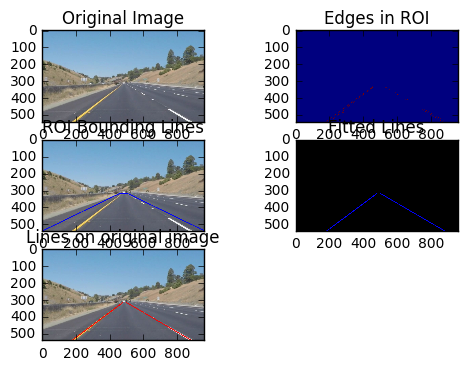

In [58]:
# Plot the results of the pipepline



# ****************** TLS fitting on edges ************************ #
for imname in images:
    try:
        image = mpimg.imread(imgfolder + imname)
        raw_image_with_lines, fitted_line_image, roi_edges = extract_lines_TLS_fitting(image)
        mpimg.imsave(imgfolder + '/labeled_TLS_' + imname,raw_image_with_lines)
    except Exception as ex:
        print('Error occurred loading: ' + str(ex))


# ****************** RANSAC fitting on edges ************************ #
for imname in images:
    try:
        image = mpimg.imread(imgfolder + imname)
        raw_image_with_lines, fitted_line_image, roi_edges = extract_lines_RANSAC_fitting(image)
        mpimg.imsave(imgfolder + 'labeled_RANSAC_' + imname,raw_image_with_lines)
    except Exception as ex:
        print('Error occurred loading: ' + str(ex))


# Plots
plt.subplot(321)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(322)
plt.imshow(roi_edges)
plt.title('Edges in ROI')
plt.subplot(323)
plt.imshow(roi_lines_image)
plt.title('ROI Bounding Lines')
plt.subplot(324)
plt.imshow(fitted_line_image)
plt.title('Fitted Lines')
plt.subplot(325)
plt.imshow(raw_image_with_lines)
plt.title('Lines on original image')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Process WITHOUT rolling average (ROLAV) filtering

### Total Least Squares Fitting

In [59]:
filtarr = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_TLS_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines

Let's try the one with the solid white lane on the right first ...

In [60]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.71 s, sys: 394 ms, total: 7.1 s
Wall time: 6.78 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Process WITHOUT rolling average (ROLAV) filtering

### RANSAC Fitting

In [62]:
filtarr = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_RANSAC_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines

In [63]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 35.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.47 s, sys: 374 ms, total: 6.85 s
Wall time: 6.53 s


In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Repeating the same pipeline with the new video
## TLS Fitting
### No filtering

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [65]:
filtarr = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_TLS_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines

In [66]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 20 s, sys: 1.11 s, total: 21.2 s
Wall time: 19.5 s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## RANSAC Fitting
### No filtering

In [69]:
filtarr = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_RANSAC_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines

In [70]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 20.1 s, sys: 1.11 s, total: 21.2 s
Wall time: 19.5 s


In [1]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

NameError: name 'HTML' is not defined

# Extrapolating detected lane lines - Comments

### Issue: Edge detection generates spurious edges 
`Road craks, reflectors, vehicle ahead, etc genrate, pixelwise, valid lines. Such artifacts are sources of noise, w.r.t line detection.`

### Dealing with 2D sources of error
`Simple fitting (LS) assumes noise only on the dependent variable (Y). In reality, noise sources from both dimensions (X, Y) - spatial perception. Moreover, using only the points returned from the cv.Hough() funtion, we get 2 points for each line. Thus, valid "long" lines carry the same weight as small suprious lines (each line is NOT as important). 

We need to let the majorty of points which - hopefully - belong to the lane lines be used for fitting. To accomplish this, I tried two methods:

1 - Total Least Squares (TLS): fit lines directly on the edge points (or otherwise known as orthogonal fitting)

2 - RANSAC: fit lines using probabilistic sampling of shape from data. This method has shown to be fairly robust to random noise, while it picks out geometrical shapes buried in such noise. It can be not as efficient as TLS (computationally) but with today's computers, we can perform magic !!
`

### How to deal with individual lane lines: Split ROI into left and right ROI
`Since the left and right lanes will be to the left and to the right, split the ROI into left and right`


### High frquency spatio-temporal noise
`It seems that the challenging video has a lot of high frequency noise in its edge generation.
The error stems from spatial spurious edges (road has faint white lie-ish patterns, switching from dark asphalt to white asphalt, other spurious objects). But in time, most of the points are fairly accurate. To deal with this, 
1 - Increase the thresholds of the edge generation to ignore faint line patterns from asphalt 
2 - Temporal rolling average filter to smoothen these fluctuations in time

Issue with priming the filter: initial values of filter are 0s. So we have floating lines until filter is filled. Better filter would be a bayesian filter (Kalman etc), or perhaps handled with care at the fusion layer.

Too high of a filterorder would not be as responsive to fast changing directions

Issue with high thresholds for edge genration: too high of a threshold would cause performance to suffer on roads with fainting lane paint`


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## TLS No - Filtering

In [72]:
filtarr = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_TLS_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines

In [73]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 20.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 13.2 s, sys: 908 ms, total: 14.1 s
Wall time: 13.1 s


In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## TLS - Filtered

In [75]:
filtsize = 10
filtarr = np.zeros((filtsize, 8), dtype=int)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_TLS_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines


challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 20.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 13.3 s, sys: 940 ms, total: 14.2 s
Wall time: 13.3 s


In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### RANSAC Filter - FIltered

In [77]:
filtsize = 10
filtarr = np.zeros((filtsize, 8), dtype=int)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    raw_image_with_lines, \
    fitted_line_image, \
    roi_edges = extract_lines_RANSAC_fitting(image=image, filtarr=filtarr)

    return raw_image_with_lines


challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 19.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14 s, sys: 1.08 s, total: 15.1 s
Wall time: 14.1 s


In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))